# IMO - Zadanie 4

Autorzy: Dariusz Max Adamski, Sławomir Gilewski

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import multiprocessing as mp
from time import time
from copy import deepcopy
plt.rc('figure', figsize=(9, 5))

In [2]:
def index(xs, e):
    try:
        return xs.index(e)
    except:
        return None
        
def find_node(cycles, a):
    i = index(cycles[0], a)
    if i is not None: return 0, i
    i = index(cycles[1], a)
    if i is not None: return 1, i
    print(cycles)
    assert False, f'City {a} must be in either cycle'
    
def remove_at(xs, sorted_indices):
    for i in reversed(sorted_indices):
        del(xs[i])

def reverse(xs, i, j):
    n = len(xs)
    d = (j - i) % n
    #print(d)
    for k in range(abs(d)//2+1):
        a, b = (i+k)%n, (i+d-k)%n
        #print(a, '<->', b)
        xs[a], xs[b] = xs[b], xs[a]

In [51]:
def distance(a, b):
    return np.round(np.sqrt(np.sum((a - b)**2)))

def read_instance(path):
    coords = pd.read_csv(path, sep=' ', names=['n','x','y'], skiprows=6, skipfooter=1, engine='python')
    cities = coords.drop(columns=['n']).values
    ns = np.arange(len(cities))
    cities = np.array([[distance(cities[i], cities[j]) for j in ns] for i in ns])
    return cities, coords

def draw_path(coords, path, color='blue'):
    cycle = path + [path[0]]
    for i in range(len(cycle) - 1):
        a, b = cycle[i], cycle[i+1]
        plt.plot([coords.x[a], coords.x[b]], [coords.y[a], coords.y[b]], color=color)

def plot_solution(coords, solution, *, labels=False):
    path1, path2 = solution
    draw_path(coords, path1, color='green')
    draw_path(coords, path2, color='red')
    plt.scatter(coords.x, coords.y, color='black')
    if labels:
        for i, x, y in zip(coords.n, coords.x, coords.y):
            plt.text(x=x+4, y=y+4, s=str(i-1), color='red', size=7, bbox=dict(facecolor='yellow', alpha=0.5))
    
def cycle_score(cities, path):
    cycle = path + [path[0]]
    return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    return cycle_score(cities, paths[0]) + cycle_score(cities, paths[1])

In [52]:
def delta_insert(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]

def solve_regret(args):
    cities, start = args
    t0 = time()
    n = cities.shape[0]
    remaining = list(range(n))
    a, b = start, np.argmax(cities[start,:])
    remaining.remove(a)
    remaining.remove(b)
    paths = [[a], [b]]
    while remaining:
        for path in paths:
            scores = np.array([[delta_insert(cities, path, i, v) for i in range(len(path))] for v in remaining])
            best_city_idx = None
            if scores.shape[1] == 1:
                best_city_idx = np.argmin(scores)
            else:
                regret = np.diff(np.partition(scores, 1)[:,:2]).reshape(-1)
                weight = regret - 0.37*np.min(scores, axis=1)
                best_city_idx = np.argmax(weight)
                
            best_city = remaining[best_city_idx]
            best_insert = np.argmin(scores[best_city_idx])
            path.insert(best_insert, best_city)
            remaining.remove(best_city)
    return time() - t0, paths

def solve_regret_init(cities, paths, remaining):
    t0 = time()
    while remaining:
        for path in paths:
            if not remaining: break
            scores = np.array([[delta_insert(cities, path, i, v) for i in range(len(path))] for v in remaining])
            best_city_idx = None
            if scores.shape[1] == 1:
                best_city_idx = np.argmin(scores)
            else:
                regret = np.diff(np.partition(scores, 1)[:,:2]).reshape(-1)
                weight = regret - 0.37*np.min(scores, axis=1)
                best_city_idx = np.argmax(weight)
                
            best_city = remaining[best_city_idx]
            best_insert = np.argmin(scores[best_city_idx])
            path.insert(best_insert, best_city)
            remaining.remove(best_city)
    return time() - t0, paths

def random_solution(n, seed=None):
    remaining = list(range(n))
    random.seed(seed)
    random.shuffle(remaining)
    return remaining[:n//2], remaining[n//2:]

In [53]:
def insert_move(moves, move):
    delta_x = move[0]
    for i, x in enumerate(moves):
        delta_y = x[0]
        if delta_x < delta_y:
            moves.insert(i, move)
            return
        elif delta_x == delta_y:
            return
    moves.append(move)

def has_edge(cycle, a, b):
    for i in range(len(cycle) - 1):
        x, y = cycle[i], cycle[i+1]
        if (a, b) == (x, y): return +1
        if (a, b) == (y, x): return -1
        
    x, y = cycle[-1], cycle[0]
    if (a, b) == (x, y): return +1
    if (a, b) == (y, x): return -1
    return 0

def any_has_edge(cycles, a, b):
    for i in range(2):
        status = has_edge(cycles[i], a, b)
        if status != 0: return i, status
    return None, 0

def delta_swap_node(D, x1, y1, z1, x2, y2, z2):
    return D[x1,y2] + D[z1,y2] - D[x1,y1] - D[z1,y1] + D[x2,y1] + D[z2,y1] - D[x2,y2] - D[z2,y2]

def make_swap_node(cities, cycles, cyc1, i, cyc2, j, calc_delta=True):
    C1, C2 = cycles[cyc1], cycles[cyc2]
    D = cities
    n, m = len(C1), len(C2)
    x1, y1, z1 = C1[(i-1)%n], C1[i], C1[(i+1)%n]
    x2, y2, z2 = C2[(j-1)%m], C2[j], C2[(j+1)%m]
    delta = delta_swap_node(cities, x1, y1, z1, x2, y2, z2) if calc_delta else 0
    move = delta, SWAP_NODE, cyc1, cyc2, x1, y1, z1, x2, y2, z2
    return delta, move

def delta_swap_edge(cities, a, b, c, d):
    if a == d or a == b or a == c or b == c or b == d or c == d: return 1e8
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

def gen_swap_edge_2(cities, cycle, i, j, calc_delta=True):
    n = len(cycle)
    nodes = cycle[i], cycle[(i+1)%n], cycle[j], cycle[(j+1)%n]
    return (delta_swap_edge(cities, *nodes), *nodes) if calc_delta else (0, *nodes)

def delta_swap_edge_2(cities, cycle, i, j):
    return gen_swap_edge_2(cities, cycle, i, j)[0]

def gen_swap_edge(n):
    return [(i, (i+d)%n) for i in range(n) for d in range(2, n-1)]

def gen_swap_node(n, m):
    return [(i, j) for i in range(n) for j in range(m)]


def init_moves(cities, cycles):
    moves = []
    for k in range(2):
        cycle = cycles[k]
        n = len(cycle)
        for i, j in gen_swap_edge(n):
            delta, a, b, c, d = gen_swap_edge_2(cities, cycle, i, j)
            if delta<0: 
                moves.append((delta, SWAP_EDGE, a, b, c, d))
    for i, j in gen_swap_node(len(cycles[0]), len(cycles[1])):
        delta, move = make_swap_node(cities, cycles, 0, i, 1, j)
        if delta<0: 
            moves.append(move)
    return moves

def get_first_edge_swap(cities, cycles, better):
    for k in random.sample(range(2), 2):
        cycle = cycles[k]
        n = len(cycle)
        candidates = gen_swap_edge(n)
        random.shuffle(candidates)
        for i, j in candidates:
            delta, a, b, c, d = gen_swap_edge_2(cities, cycle, i, j, calc_delta=better)
            if not (delta >= 0 and better):
                return (delta, SWAP_EDGE, a, b, c, d)
    return None
    
def get_first_node_swap(cities, cycles, better):
    candidates = gen_swap_node(len(cycles[0]), len(cycles[1]))
    random.shuffle(candidates)
    for i, j in candidates:
        delta, move = make_swap_node(cities, cycles, 0, i, 1, j, calc_delta=better)
        if not (delta >= 0 and better): 
            return move
    return None
        
def get_move(cities, cycles, calc_delta=True):
    moves = [get_first_edge_swap, get_first_node_swap]
    move_order = random.sample(range(2), 2)
    move = moves[move_order[0]](cities, cycles, calc_delta)
    if move is None: 
        move = moves[move_order[1]](cities, cycles, calc_delta)
    return move


SWAP_EDGE, SWAP_NODE = range(2)
def apply_move(cycles, move):
    kind = move[1]
    if kind == SWAP_EDGE:
        _, _, a, _, c, _ = move
        (c1, i), (c2, j) = find_node(cycles, a), find_node(cycles, c)
        #print('swap edge', c1, i, c2, j, move[0])
        #assert c1 == c2, 'Cannot swap edges between cycles'
        cycle = cycles[c1]
        n = len(cycle)
        reverse(cycle, (i+1)%n, j)
    elif kind == SWAP_NODE:
        _, _, c1, c2, _, a, _, _, b, _ = move
        i, j = cycles[c1].index(a), cycles[c2].index(b)
        #print('swap node', c1, i, c2, j, move[0])
        #assert c1 != c2, 'Cannot swap nodes in the same cycle'
        cycles[c1][i], cycles[c2][j] = cycles[c2][j], cycles[c1][i]
    else:
        assert False, 'Invalid move type'

In [55]:
class SearchGreedy:
    def __init__(self, cities):
        self.cities = cities
    
    def __call__(self, cycles, inplace=False):
        if not inplace:
            cycles = deepcopy(cycles)
        start = time()
        while True:
            move = get_move(self.cities, cycles)
            if move is None: break
            apply_move(cycles, move)
        return time() - start, cycles

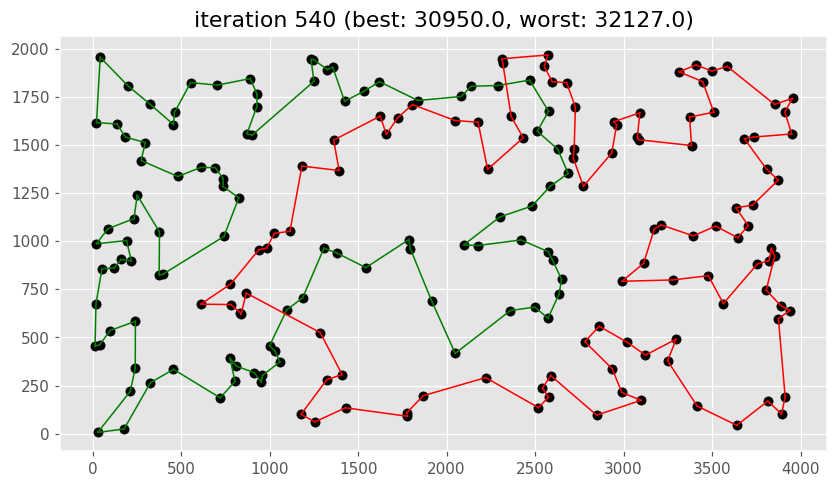

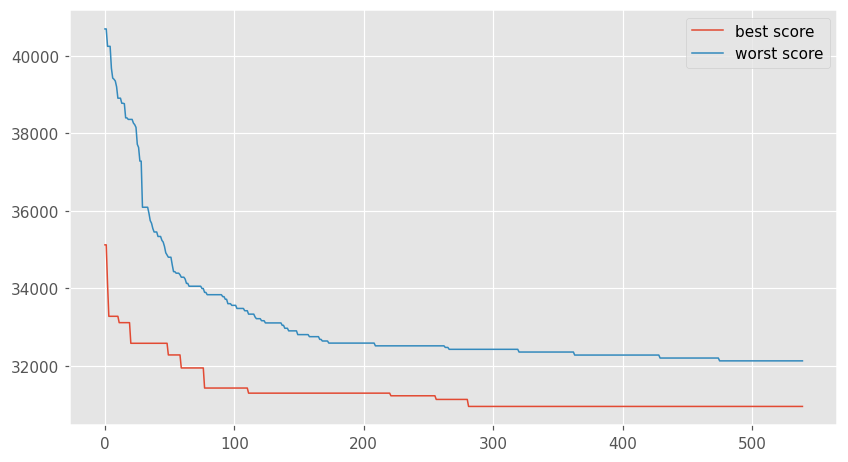

600.0212471485138


In [68]:
from IPython.display import clear_output
from time import sleep
from tqdm import tqdm
from copy import deepcopy

def identity(x):
    return x

def argmax(x, f=identity):
    return max(np.arange(len(x)), key=lambda i: f(x[i]))

def argmin(x, f=identity):
    return min(np.arange(len(x)), key=lambda i: f(x[i]))

class EvoSearch:
    def __init__(self, cities, coords):
        self.cities, self.coords = cities, coords

    def combine(self, sol1, sol2):
        sol1, sol2 = deepcopy(sol1), deepcopy(sol2)
        
        remaining = []
        for cyc1 in sol1:
            n = len(cyc1)
            if n == 1:
                continue
            for i in range(n):
                p, q = cyc1[i], cyc1[(i+1)%n]
                if p == -1 or q == -1 or p == q:
                    continue
                found = False
                for cyc2 in sol2:
                    m = len(cyc2)
                    for j in range(m):
                        u, v = cyc2[j], cyc2[(j+1)%m]
                        if (p == u and q == v) or (p == v and q == u):
                            found = True
                            break
                    if found:
                        break
                        
                if not found:
                    remaining.append(cyc1[i])
                    remaining.append(cyc1[(i+1)%n])
                    cyc1[i] = -1
                    cyc1[(i+1)%n] = -1
                    
            for i in range(1, n):
                x, y, z = cyc1[(i-1)%n], cyc1[i], cyc1[(i+1)%n]
                if x == z == -1 and y != -1:
                    remaining.append(y)
                    cyc1[i] = -1
                    
            for i in range(1, n):
                x = cyc1[i]
                if x != -1 and np.random.rand() < 0.2:
                    remaining.append(x)
                    cyc1[i] = -1
                    
        a = [x for x in sol1[0] if x != -1]
        b = [x for x in sol1[1] if x != -1]
        assert len(a) + len(b) + len(remaining) == 200
        return solve_regret_init(self.cities, (a, b), remaining)[1]
    
    def perturb(self, cycles, strength=0.2):
        to_destroy = int(strength*len(self.cities)/2)
        
        remaining = []
        for cycle in cycles:
            n = len(cycle)
            destroy_begin = random.randint(0, n - 1)
            remaining.extend(cycle[destroy_begin : destroy_begin + to_destroy])
            cycle[destroy_begin : destroy_begin + to_destroy] = []

            if destroy_begin + to_destroy > n:
                remaining.extend(cycle[0 : destroy_begin + to_destroy - n])
                cycle[0 : destroy_begin + to_destroy - n] = []
    
        return solve_regret_init(self.cities, cycles, remaining)[1]
    
    def __call__(self, *, pop_size=20, t_limit=10, min_diff=40, plot=False, mutate=40, patience=300, with_local=True):
        local_search = SearchGreedy(self.cities)
        t_start = time()
        pop = [local_search(random_solution(len(self.cities)))[1] for _ in tqdm(range(pop_size))]
        pop = [(x, score(self.cities, x)) for x in pop]
        best_scores = []
        worst_scores = []
        
        fine_tune = False
        iteration = last_improv = 0
        last_best = pop[0][1]
        best_idx = 0
        last_mutate = 0
        while time() - t_start < t_limit:
            iteration += 1
            
            pop_idx = np.arange(len(pop))
            np.random.shuffle(pop_idx)

            # find the worst solution in population 
            worst_idx = argmax(pop, lambda x: x[1])
            worst_sol, worst_score = pop[worst_idx]
                
            # select random two parents, combine & score
            sol1, sol1_score = pop[pop_idx[0]]
            sol2, sol2_score = pop[pop_idx[1]]
            sol = self.combine(sol1, sol2)
            if with_local:
                sol = local_search(sol, inplace=True)[1]
            sol_score = score(self.cities, sol)
            print(f'{sol1_score} + {sol2_score} -> {sol_score}')
            
            too_similar = any(abs(sol_score - s) < min_diff for _, s in pop)
            if sol_score < last_best:
                pop[best_idx] = sol, sol_score
            elif sol_score < worst_score and not too_similar:
                pop[worst_idx] = sol, sol_score

            # show best solution in population
            best_idx = argmin(pop, lambda x: x[1])
            best_sol, best_score = pop[best_idx]
            best_scores.append(best_score)
            worst_scores.append(worst_score)
            
            if best_score < last_best:
                last_best = best_score
                last_improv = iteration
            
            #if iteration - last_improv > mutate and iteration - last_mutate > mutate:
            #    last_mutate = iteration
            #    for i in pop_idx:
            #        if i == best_idx: continue
            #        sol, _ = pop[i]
            #        sol = self.perturb(sol, strength=np.random.rand()*0.75)
            #        sol = local_search(sol, inplace=True)[1]
            #        sol_score = score(self.cities, sol)
            #        pop[i] = sol, sol_score
                    
            if iteration - last_improv > patience:
                break
                    
            if plot:
                clear_output(wait=True)
                plt.figure()
                plot_solution(coords, best_sol)
                plt.title(f'iteration {iteration} (best: {best_score}, worst: {worst_score})')
                plt.show()
                plt.figure()
                plt.plot(best_scores, label='best score')
                plt.plot(worst_scores, label='worst score')
                plt.legend()
                plt.show()
            
        return time() - t_start, best_sol

cities, coords = read_instance('kroA200.tsp')
evo_search = EvoSearch(cities, coords)
dt, sol = evo_search(plot=True, t_limit=60*10, with_local=True, patience=1000)
print(dt)